# Rasterize Lidar point clouds, mosaic observations captured same day

In [1]:
import os
import glob
import subprocess
import xarray as xr
import rioxarray as rxr
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
json_fn = "/Users/raineyaberle/Research/PhD/SnowDEMs/snow-dems/pdal_pipeline.json"
in_dir = "/Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310"
out_dir = in_dir
resolution = 10

## Rasterize individual LAZ files using PDAL

In [3]:
# Grab all LAZ file names
fns = sorted(glob.glob(os.path.join(in_dir, '*.laz')))

# Iterate over files
for fn in tqdm(fns):
    # Remove spaces and dashes from file name (causes issues with subprocess)
    bn = os.path.basename(fn)
    bn_new = fn.replace(' ','').replace('-','_')
    os.rename(os.path.join(in_dir, bn), os.path.join(in_dir, bn_new))

    # Run the PDAL pipeline if output file doesn't exist
    out_fn = os.path.join(out_dir, bn_new.replace('.laz', f'_{resolution}m.tif'))
    if not os.path.exists(out_fn):
        cmd = f"pdal pipeline {json_fn} --readers.las.filename={fn} --writers.gdal.resolution={resolution} --writers.gdal.filename={out_fn}"
        output = subprocess.run(cmd, shell=True, capture_output=True)
    

  0%|          | 0/8 [00:00<?, ?it/s]

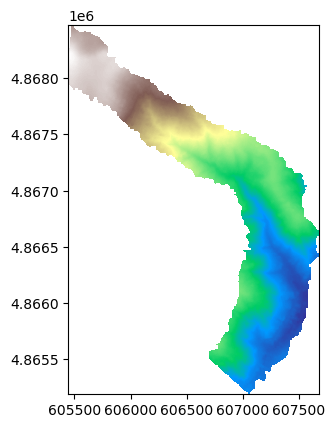

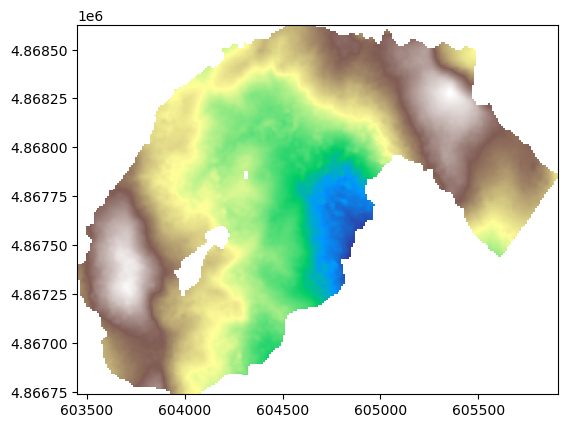

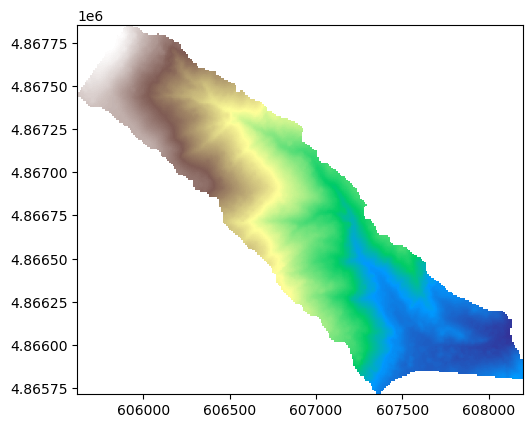

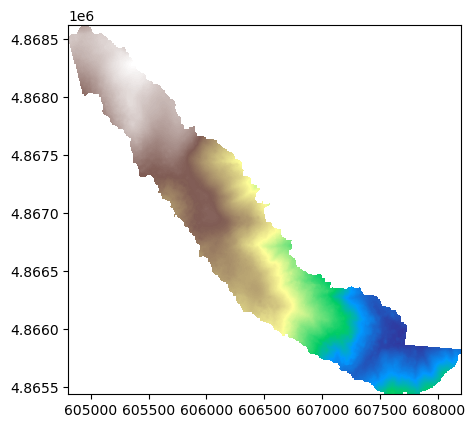

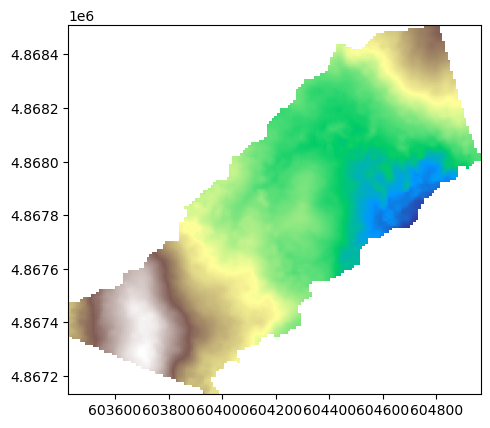

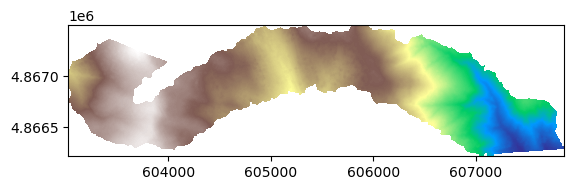

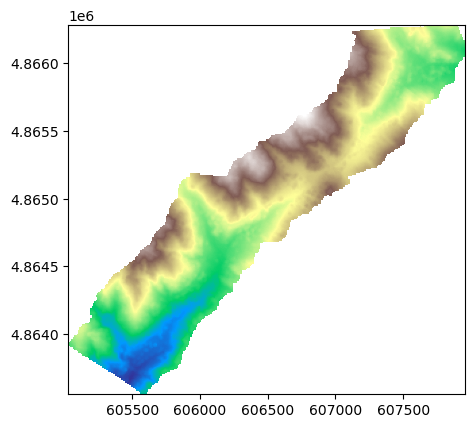

In [4]:
# Optional: Plot TIF files
fns = sorted(glob.glob(os.path.join(out_dir, f'*_{resolution}m.tif')))
for fn in fns:
    im = xr.open_dataset(fn)
    plt.imshow(im.band_data[0].data, cmap='terrain',
               extent=(np.min(im.x.data), np.max(im.x.data), 
                       np.min(im.y.data), np.max(im.y.data)))
    plt.show()

## Mosaic all TIFs from same date

In [5]:
fns = sorted(glob.glob(os.path.join(out_dir, f'*_{resolution}m.tif')))
out_fn = os.path.join(out_dir, 
                      os.path.basename(fns[0])[0:14] + f"_{resolution}m_MOSAIC.tif")

if not os.path.exists(out_fn):
    cmd = f"gdal_merge.py"
    for fn in fns:
        cmd += f" {fn}"
    
    cmd += f" -o {out_fn}"
    
    output = subprocess.run(cmd, shell=True, capture_output=True)
    print(output)

CompletedProcess(args='gdal_merge.py /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_194054_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_194355_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_194823_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_195033_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_195347_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_195459_VQ_580_originalpoints_10m.tif /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10_MCS_VQ_580_210310_195852_VQ_580_originalpoints_10m.tif -o /Users/raineyaberle/Research/PhD/SnowDEMs/MCS/lidar/20210310/2021_03_10

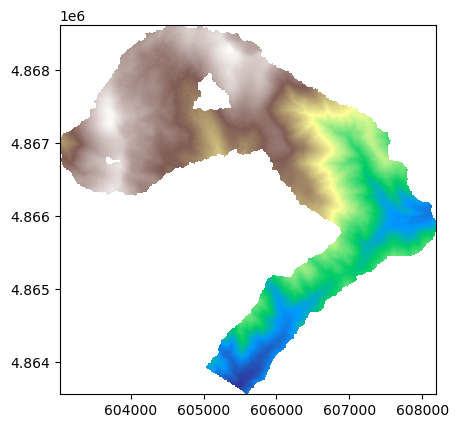

In [6]:
# Load and plot
im = xr.open_dataset(out_fn)
im = xr.where(im==0, np.nan, im)
plt.imshow(im.band_data[0].data, cmap='terrain',
               extent=(np.min(im.x.data), np.max(im.x.data), 
                       np.min(im.y.data), np.max(im.y.data)))
plt.show()